In [26]:
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import PandasTools
import zipfile
from io import BytesIO

import selfies as sf

import sys
sys.path.append("..")
import moses
from moses.vae import VAE
from moses.vae_property import VAEPROPERTY
from moses.utils import CharVocab, StringDataset, SELFIESVocab
from moses.vae.trainer import VAETrainer
from moses.vae_property.trainer import VAEPROPERTYTrainer 

from moses.metrics import QED, SA, logP
from moses.utils import get_mol

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [27]:
model_name = 'SMILES_VAEProp_all'
folder_path = "../checkpoints/ZINC250K_vae_property_obj_proploss_w0.1"
config = torch.load(f'{folder_path}/vae_property_config.pt')
vocab = torch.load(f'{folder_path}/vae_property_vocab.pt')

print(f"Use Selfies: {config.use_selfies}")

Use Selfies: False


In [28]:


train_data = pd.read_csv('../moses/dataset/data/ZINC250K/train.csv')
cols = ['SELFIES' if config.use_selfies else 'SMILES', 'logP', 'qed', 'SAS', 'obj']
train_data = train_data[cols].values
#size = len(train_data)
#np.random.seed(0)
#rand_indices = np.random.choice(train_data.shape[0], size, replace=False)
#train_data = train_data[rand_indices]

for i, epoch in enumerate(['hi']):
# for i, epoch in enumerate(['00', 20, 40]):
    model_path = f'{folder_path}/vae_property_model.pt'
    if config.model == 'vae':
        model = VAE(vocab, config)
    elif config.model == 'vae_property':
        model = VAEPROPERTY(vocab, config)

    model.load_state_dict(torch.load(model_path))
    
    trainer = VAEPROPERTYTrainer(config)
    sample_loader = trainer.get_dataloader(model, train_data, shuffle=False)
    
    
    model.eval()

    z_list = []
    y_list = []
    for step, batch in enumerate(sample_loader):
        if len(batch[0]) == config.n_batch:
            input_batch = tuple(data.to(model.device) for data in batch[0])
            y = batch[1]
            mu, logvar, z, kl_loss = model.forward_encoder(input_batch)
            z = mu.detach().cpu().numpy()
            z_list.extend(z)
            y_list.append(np.array(y).squeeze())

    z_list = np.array(z_list).squeeze()
    y_list = np.array(y_list)
    y_list = y_list.squeeze()
    y_list = y_list.reshape(-1, y_list.shape[-1])
    
    # z_viz = TSNE(n_components=2).fit_transform(z_list)

    viz = PCA(n_components=2)
    z_viz = viz.fit_transform(z_list)
    explained_variance = viz.explained_variance_ratio_
    print(f"Explained variance: {explained_variance}")


    # print(z_viz.shape)
    z_viz = MinMaxScaler().fit_transform(z_viz)

    

Explained variance: [0.21027812 0.13507722]


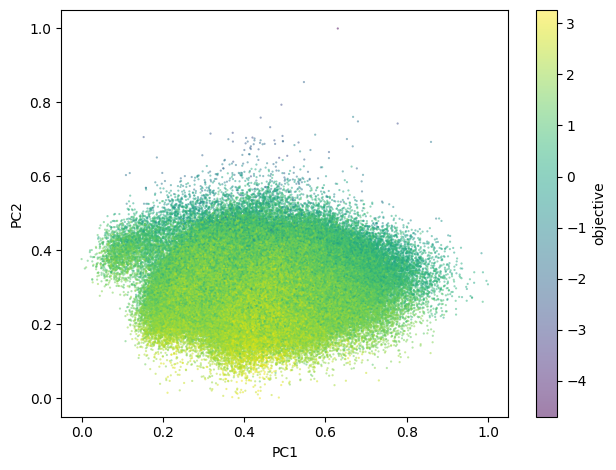

In [29]:
plt.plot(figsize=(20, 20))

for i, prop in enumerate(['obj']):
    plt.scatter(z_viz[:,0], z_viz[:,1], c=y_list[:, -1], cmap='viridis', marker='.', s=10, alpha=0.5, edgecolors='none')
    #plt.set_title(f'{prop}')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    # axes[i].text(0.75, 0.2, f"Explained (PC1): {round(explained_variance[0],2)}", transform=axes[i].transAxes)
    # axes[i].text(0.75, 0.1, f"Explained (PC2): {round(explained_variance[1],2)}", transform=axes[i].transAxes)
    plt.colorbar(label='objective')
    
plt.tight_layout()
# save figure in high quality

plt.savefig(f'../results/obj_pca_{model_name}.png', dpi=1000)

plt.show()


In [30]:
model_name

'SMILES_VAEProp_all'